# Quantifying Luck in Sports Betting

Are you bad, or unlucky? Even if your model is perfect, there's a lot of luck involved in sports betting. This notebook will show how to find the distribution of possible outcomes after a series of bets, elucidating how you actual performance compares to the range of possible outcomes. This notebook tackles the *descriptive* problem of contextualizing past performance assuming you have the size of, the probability of winning, and the potential profits for each bet.

## Data Cleaning

First, I import the relevant libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Next, I read in the data to a pandas dataframe. This is a self-made csv file containing information for every bet made. Details on how to scrape data to create this file are given in a different notebook, but for this project I'll assume no prior knowledge of the data. The first column in the csv is the dataframe's index.

In [2]:
bet_df = pd.read_csv('./bets.csv', index_col=0)

Let's look at some of the data.

In [3]:
bet_df.head()

,Team,Opponent,Moneyline,Model,Profit,EV,Bet size,Time,Results
Date,,,,,,,,,
2/11/21,ORL,GSW,300.0,0.31,6.00,0.48,2,00:00.0,0.0
2/11/21,POR,PHI,175.0,0.39,3.50,0.15,2,00:00.0,1.0
2/12/21,POR,CLE,-185.0,0.74,2.16,0.56,4,00:00.0,1.0
2/12/21,UTA,MIL,-145.0,0.68,2.76,0.60,4,00:00.0,1.0
2/12/21,ATL,SAS,-145.0,0.63,1.38,0.13,2,00:00.0,0.0


There are some identifiers (**date**, **timestamp**, **team**, **opponent**), **bet size** is, unsurprisingly, the size of the bets, and **results** indicate if the bet won (1) or lost (0). The most interesting columns are the **moneyline**, **model**, **profit**, and **EV**. For every bet, we have a model the predicts the likelihood of winning the bet. Building an accurate betting model is an interesting (and challenging!) project, but it isn't the focus here. For the rest of the project, I assume that the betting model is "correct". In other words, if it predicts the NY Knicks to win 56% of the time, then they win 56% of the time. 

**Moneyline** contains the odds the sportsbook gives for a bet. The syntax can be confusing though, so instead we'll deal with odds in terms of the **profit**, which is the potential winnings if the bet is successful. 

Finally, there is the **expected value**, or **EV**. Assuming the model is correct, and given the potential profit, this is the expected amount of winnings from this bet on average. More EV = more profit = a better bet for us.

Taking it all together, with an example: on 2/11, the bettor bet of \\$2 on the Orlando Magic (ORL) to beat the Golden State Warriors (GSW) for a potential profit of \\$6.00 and expected winnings of \\$0.48. The Magic lost, and so the bettor lost \\$2. 

Looking at another section of the data shows that I need to process the data a bit before analysis.

In [4]:
bet_df.loc['2/21/21', :]

,Team,Opponent,Moneyline,Model,Profit,EV,Bet size,Time,Results
Date,,,,,,,,,
2/21/21,ORL,DET,-145.0,0.72,1.38,0.43,2,00:00.0,1.0
2/21/21,NOP,BOS,110.0,0.53,2.20,0.23,2,00:00.0,1.0
2/21/21,TOR,PHI,120.0,0.54,2.40,0.38,2,00:00.0,1.0
2/21/21,TOR,PHI,115.0,0.54,2.30,0.32,2,00:00.0,1.0
2/21/21,BKN,LAC,195.0,0.27,3.90,-0.41,2,00:00.0,1.0


All bets are made pre-game, and there are no situations where there is a bet made on both teams in a game. However, there are a few instances of multiple bets on the same game. This breaks the assumption that each bet is independent, and if not addressed it will lead to overly wide uncertainties (the bettor won both, which happens 54% of the time, but the analysis would assume winning both happens 54\%\*54\% = 29\% of the time.)

To fix this, we have to group these data together, grouping on the index and column **Date** and **Team**.

In [5]:
grouped = bet_df.groupby(['Date', 'Team'])
type(grouped)

pandas.core.groupby.generic.DataFrameGroupBy

This leaves up with a groupby object that we need to aggregate back into a dataframe. To do this, we must combine the multiple values in order to have one row of data for a given **Date** and **Team**. I use the flexible .agg() method:

In [6]:
bets_df2 = grouped.agg(**{"Model": ("Model", np.mean),
                          "Results": ("Results", np.mean),
                          "Bet size": ("Bet size", sum),
                          "Profit": ("Profit", sum),
                          "EV": ("EV", sum)})

This creates a new dataframe with columns **Model**, **Results**, **Bet size**, **Profit**, and **EV**. **Date** and **Team** are automatically passed to the new dataframe as indices. The other columns are irrelevant for this analysis.

The unpacked dictionary format (\*\*{}) allows for nonstandard column names (such as the space in "Bet size"), and it allows for a different aggregation method for each column. I average the model predictions, which are almost always unchanged between bets, and the results. The remaining columns are additive, e.g., two \\$2 bets are equivalent to one \\$4 bet. 

Finally, we change **Team** from an index back to a column, to keep the same format as before.

In [7]:
bets_df2 = bets_df2.reset_index('Team')
bets_df2.loc['2/21/21', :]

,Team,Model,Results,Bet size,Profit,EV
Date,,,,,,
2/21/21,BKN,0.27,1.0,2,3.90,-0.41
2/21/21,NOP,0.53,1.0,2,2.20,0.23
2/21/21,ORL,0.72,1.0,2,1.38,0.43
2/21/21,TOR,0.54,1.0,4,4.70,0.70


The two Toronto (TOR) bets have been combined into a single bet, as expected. As a last step, I append a zero to the start of each array to make it so the starting profit is \$0 and the first bet is at n=1. 

In [8]:
probs = np.append([0], bets_df2['Model'].values)
bet_sizes = np.append([0], bets_df2['Bet size'].values)
profits = np.append([0], bets_df2['Profit'].values)
results = np.append([0], bets_df2['Results'].values)
nBets = len(probs)
nBets_array = np.arange(nBets)

## Monte Carlo Analysis

Now the data is ready for analysis. First, I use the input arrays to calculate the total profits after each bet.

In [9]:
# If the bet is succesful, they win the profits. If unsuccessful, they lose the bet size.
# Use np.cumsum() to get total profit after each bet.
actual_profits = np.cumsum(results*profits - (1-results)*bet_sizes)

It's not obvious that there's a closed-form solution to the probability distribution of the total profits after N bets with X probability of success (that are all different) and Y potential profits (spoiler: there actually is! I'll break this down in a future project). The easy way out, which requires no knowledge of strange probability distribtutions, is to do a **Monte Carlo analysis**. This involves simulating the results of each bet in the series and recording the cumulative profit for that single run. This *samples* the true distribution. Do many more simulations, and this can create enough samples to effectively recreate the underlying distribution. We can then see where the actual results lie on the distribution of possible outcomes.

First, set the number of samples. I choose N=50000 as a starting point.

In [10]:
n = 50000

Next, I simulate the data. I handle this by randomly generating a number from the uniform distribution between 0 and 1. In other words, all numbers between 0 and 1 are equally likely. If the random number is less than the probability of success, then the bet is successful. Otherwise, it isn't. 

I do this once for each bet in the series, and once for each simulation of the series of bets, so I need (N x nBets) array of random numbers.

In [11]:
sim = np.random.uniform(size=(n, nBets))

Next, change the dimension of the model probability array in order to match the dimensions of the simulated data and avoid for loops. The np.tile() functions will create N copies of the *probs* array.

In [12]:
prob = np.tile(probs, (n, 1))
print("First copy: ", prob[0, :])
print("Last copy:", prob[-1,:])
print("Copies match:", np.all(prob[0, :] == prob[-1, :]))

First copy:  [0.    0.31  0.39  0.63  0.74  0.68  0.76  0.69  0.59  0.47  0.26  0.23
 0.76  0.76  0.58  0.42  0.44  0.58  0.47  0.6   0.38  0.44  0.36  0.5
 0.46  0.5   0.59  0.57  0.36  0.74  0.27  0.53  0.72  0.54  0.77  0.33
 0.76  0.78  0.33  0.81  0.56  0.72  0.57  0.68  0.62  0.85  0.81  0.84
 0.335]
Last copy: [0.    0.31  0.39  0.63  0.74  0.68  0.76  0.69  0.59  0.47  0.26  0.23
 0.76  0.76  0.58  0.42  0.44  0.58  0.47  0.6   0.38  0.44  0.36  0.5
 0.46  0.5   0.59  0.57  0.36  0.74  0.27  0.53  0.72  0.54  0.77  0.33
 0.76  0.78  0.33  0.81  0.56  0.72  0.57  0.68  0.62  0.85  0.81  0.84
 0.335]
Copies match: True


Next, I determine the success of each bet in each simulated run. As a sanity check, see that the percent of successful simulated bets is equal to the probability of that bet being successful.

In [13]:
correct = sim < prob
print('Model Probability for bet 1: %.0f%%' % (prob[1,1]*100))
print('Corresponding percent of successful simulated bets: %.2f%%' % (correct[:, 1].mean()*100))

Model Probability for bet 1: 31%
Corresponding percent of successful simulated bets: 30.88%


Side note: This won't be an exact match, because this inherently comes with some sampling error, which scales as $1/\sqrt{N}$. Typically, the distribution is considered converged (i.e, adequately sampled) when the sampling error is some small percent (e.g, 1\%) of the mean. The convergence of interest is the expected profits --- which is more complicated and should take more points than that of a single bet --- so I won't explicitly calculate convergence until later. 

Back to the analysis: I convert the settled bets to money won (or lost) by each bet. Then, I use np.cumsum() to get the cumulative winnings after each bet for each simulated series.

In [14]:
money = correct*profits - (1-correct)*bet_sizes
# Get cumulative winnings after each bet in the series.
winnings = money.cumsum(axis=1)
winnings.shape

(50000, 49)

### Visualizing Results

The *winnings* array contains 50000 samples of the distribution of cumulative profit at each of the 48 bets in the series. This provides the potential range of profits at every point in the series of bets. 

As an example, here are histograms showing the distributions at n=1, n=3, and n=40. As expected, the probability distribution for a single bet is binomial. After 3 bets, the distribution is sort of multinomial. By the 40th bet, the distribution resembles a Gaussian distribution.

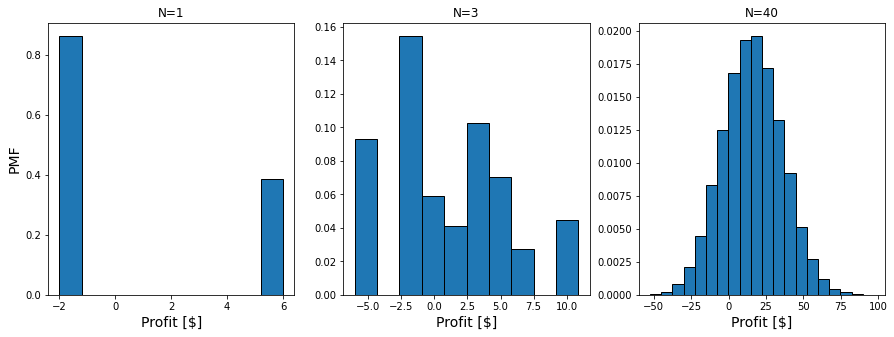

In [15]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].hist(winnings[:,1], density=True, edgecolor='k')
axes[1].hist(winnings[:,3], density=True, edgecolor='k')
axes[2].hist(winnings[:,-1], density=True, edgecolor='k', bins=20)
axes[0].set_title('N=1')
axes[1].set_title('N=3')
axes[2].set_title('N=40')
axes[0].set_ylabel('PMF', size=14)
axes[0].set_xlabel('Profit [$]', size=14)
axes[1].set_xlabel('Profit [$]', size=14)
axes[2].set_xlabel('Profit [$]', size=14)
plt.show()

I'm more interested in the evolution of the profit after a series of bets. Let's visualize the *winnings* array another way by plotting 100 random bet-chains, and compare that to the actual profits.

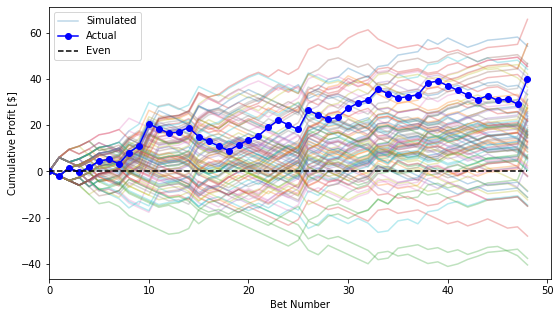

In [16]:
# Index to randomly get 100 of the 50000 simulations.
inds = np.random.randint(n, size=100)
# Define array of bet numbers for plotting.
bet_number = np.arange(nBets)
# Plot each random bet chain, only labeling the first one.
fig, ax = plt.subplots(figsize=(9,5))
for i, ind in enumerate(inds):
    bet_series = winnings[ind]
    if i==0:
        plt.plot(bet_number, bet_series, alpha=0.3, label='Simulated')
    else:
        plt.plot(bet_number, bet_series, alpha=0.3)
# Plot the actual results.
ax.plot(bet_number, actual_profits, label='Actual', color='b', marker='o')
# Plot zero-line.=
ax.plot(bet_number, np.zeros_like(bet_number), label='Even', ls='--', color='k')
ax.set_xlabel('Bet Number')
ax.set_xlim(left=0)
ax.set_ylabel('Cumulative Profit [\$]')
ax.legend()
plt.show()

Despite being based on the exact same model and having the exact same EV, outcomes range from being up \\$60 to being down \\$30 after almost 50 bets. With a rough idea of the range of outcomes in mind, this contextualizes how lucky the bettor has been. They have a profit of around \\$40, clearly in the top 50\% of outcomes. 

Next, I calculate some descriptive stats to better quantify the distributions. 

In [17]:
# Get the mean of the expected value (expected profit) at each bet.
mean_evs = np.mean(winnings, axis=0)
# Get the standard deviation at each point.
std_evs = np.std(winnings, axis=0)
# Get the median, 1-sigma, and 2-sigma quantiles (68-95-99.7 rule).
# 1-sigma quantiles contain 68% of the outcomes (probability mass).
# 2-sigma quantiles contain 95% of the outcomes.
median_ev = np.percentile(winnings, 50, axis=0)
lower2_ev = np.percentile(winnings, 2.5, axis=0)
lower_ev = np.percentile(winnings, 16, axis=0)
upper_ev = np.percentile(winnings, 84, axis=0)
upper2_ev = np.percentile(winnings, 97.5, axis=0)
# Determine what percentile in the distribution the actual results are at.
observed_percentiles = np.sum(winnings<actual_profits, axis=0)/n*100
print('Mean EV at most recent bet: $%.2f' % (mean_evs[-1]))
print('EV uncertainty at most recent bet: $%.2f' % (std_evs[-1]))
print('Actual Results at most recent bet: $%.2f' % (actual_profits[-1]))
print('Percentile of actual results at most recent bet: %.2f%%:' % (observed_percentiles[-1]))

Mean EV at most recent bet: $15.81
EV uncertainty at most recent bet: $19.77
Actual Results at most recent bet: $39.96
Percentile of actual results at most recent bet: 88.67%:


With these stats in hand, I can plot the actual results over the 95\% range derived from the Monte Carlo analysis. 

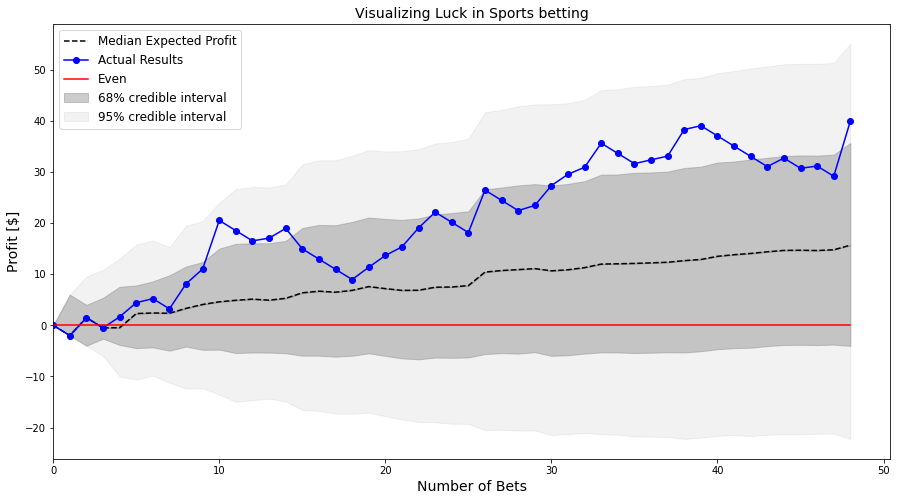

In [18]:
fig, ax = plt.subplots(figsize=(15,8))
ax.fill_between(bet_number, median_ev, upper_ev, color='grey', alpha=.4)
ax.fill_between(bet_number, median_ev, lower_ev, color='grey', alpha=.4, label='68% credible interval')
ax.fill_between(bet_number, median_ev, upper2_ev, color='grey', alpha=.1)
ax.fill_between(bet_number, median_ev, lower2_ev, color='grey', alpha=.1, label='95% credible interval')
ax.plot(bet_number, median_ev, color='k', ls='--', label='Median Expected Profit')
ax.plot(bet_number, actual_profits, 'bo', ls='-', label='Actual Results')
ax.plot(bet_number, np.zeros_like(bet_number), color='r', label='Even')
ax.set_xlim(left=0)
ax.set_xlabel('Number of Bets', size=14)
ax.set_ylabel('Profit [$]', size=14)
ax.set_title('Visualizing Luck in Sports betting', size=14)
ax.legend(numpoints=1, loc="upper left", prop={'size': 12})
plt.show()

The bettor has been pretty lucky, with a total profit falling in the top 88% of potential outcomes as of the most recent bet. Interestingly, even though the bettor's median expected return is $16 after ~50 bets (a 15\% return on investment!), they still lose money almost 20\% of the time due to high variance. So before you throw out the model you poured your heart into, make sure you aren't losing purely due to random chance!

### Appendix: Convergence 

With the mean and standard deviation, I can gauge convergence. I'll focus specifically on the distribution at the final bet, assuming that since it's dependent on the most points it'll be the most difficult to converge on. The sampling error on the mean is $\sigma_{mc} = \sigma/\sqrt{N}$. For N=50000, the sampling error is:

In [19]:
# Determine the Monte carlo error relative to the mean.
mc_error = std_evs[-1]/np.sqrt(n)
relative_error = mc_error/mean_evs[-1]*100
print('Absolute Monte Carlo Error: $%.2f' % (mc_error))
print('Monte Carlo Error Relative to the Mean: %.2f%%' % (relative_error))

Absolute Monte Carlo Error: $0.09
Monte Carlo Error Relative to the Mean: 0.56%


Every time I run this simulation, I can expect the mean expected profit at the most recent bet to differ on the order of 9 cents. This measly 0.56% error is tolerable and below the rough 1% threshhold, so 50000 runs is sufficient.

I can also verify convergence less quantitatively, by verifying repeatability. This is a more common sense way that works well in this case since I don't require too much detail: I'm most interested in the rough distribution range, and a change of 50 cents doesn't impact that too much. If the outputs of the simulation (e.g., the above figure, or the histograms for each bet) look the same each time the program is run, then it's likely convergence is achieved. If the outputs vary significantly between runs, then a larger N is necessary.